Research Ques3: To what extent can the engagement metrics from Reddit (e.g., post popularity, comments, sentiment) and Spotify (e.g., daily top hits, artist details, popularity index) predict the commercial success and overall popularity of artists, and are there specific patterns or trends that indicate a higher likelihood of success within the music industry (sentiment analysis on the comments) ?

Lets plot a graph for atists vs. their popularity index - to check the fan following and it looks like artists such as Taylor Swift, Bad Bunny, Travis Scott, The Weekend have a highest popularity for year 2023.

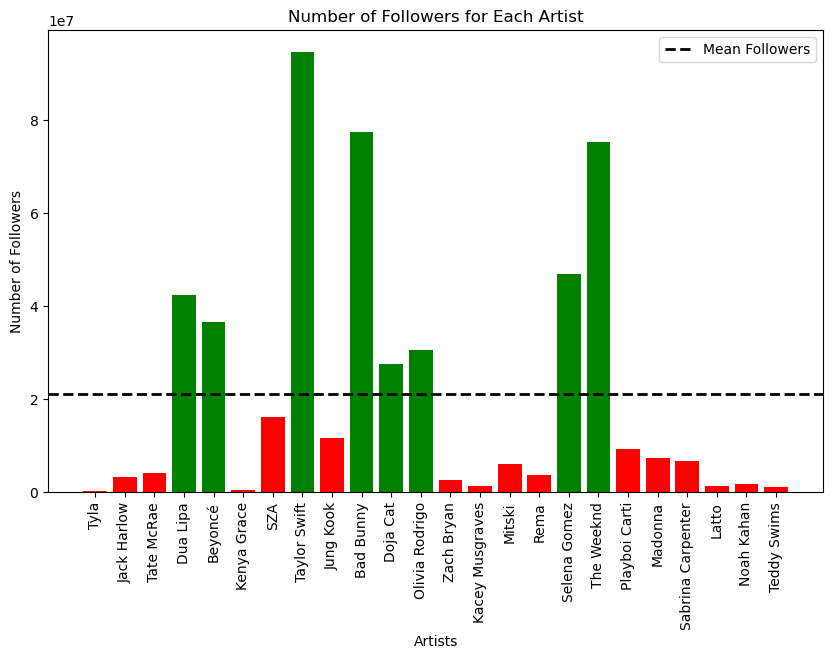

Mean Absolute Error: 18129567.31363738
Mean Squared Error: 454410823986060.5
Root Mean Squared Error: 21316914.035245825


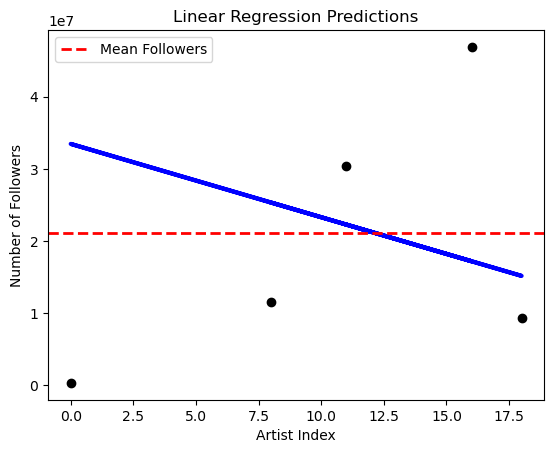

In [1]:
import matplotlib.pyplot as plt
import pymongo
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_details

artists_data = list(collection.find({}))

artists = [artist['name'] for artist in artists_data]
followers = [artist['followers']['total'] for artist in artists_data]

mean_followers = np.mean(followers)

colors = ['green' if follower > mean_followers else 'red' for follower in followers]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(artists, followers, color=colors)

ax.axhline(mean_followers, color='black', linestyle='--', linewidth=2, label='Mean Followers')

ax.set_xlabel('Artists')
ax.set_ylabel('Number of Followers')
ax.set_title('Number of Followers for Each Artist')
ax.tick_params(axis='x', rotation=90)
ax.legend()

plt.show()

followers = [artist['followers']['total'] for artist in artists_data]

artist_indices = list(range(len(artists_data)))

df = pd.DataFrame({'ArtistIndex': artist_indices, 'Followers': followers})

X = df[['ArtistIndex']]
y = df['Followers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred, squared=False))

plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.axhline(mean_followers, color='red', linestyle='--', linewidth=2, label='Mean Followers')
plt.xlabel('Artist Index')
plt.ylabel('Number of Followers')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()




Plotting a graph for Artists vs discusiions activity in their official subreddits for 10 consecutive days.

Established artists like TheWeekend, Travis Scott, Playbot Carti, Doja Cat, Taylor Swift have more activity in their subreddits. (approx 50-70 posts/day)

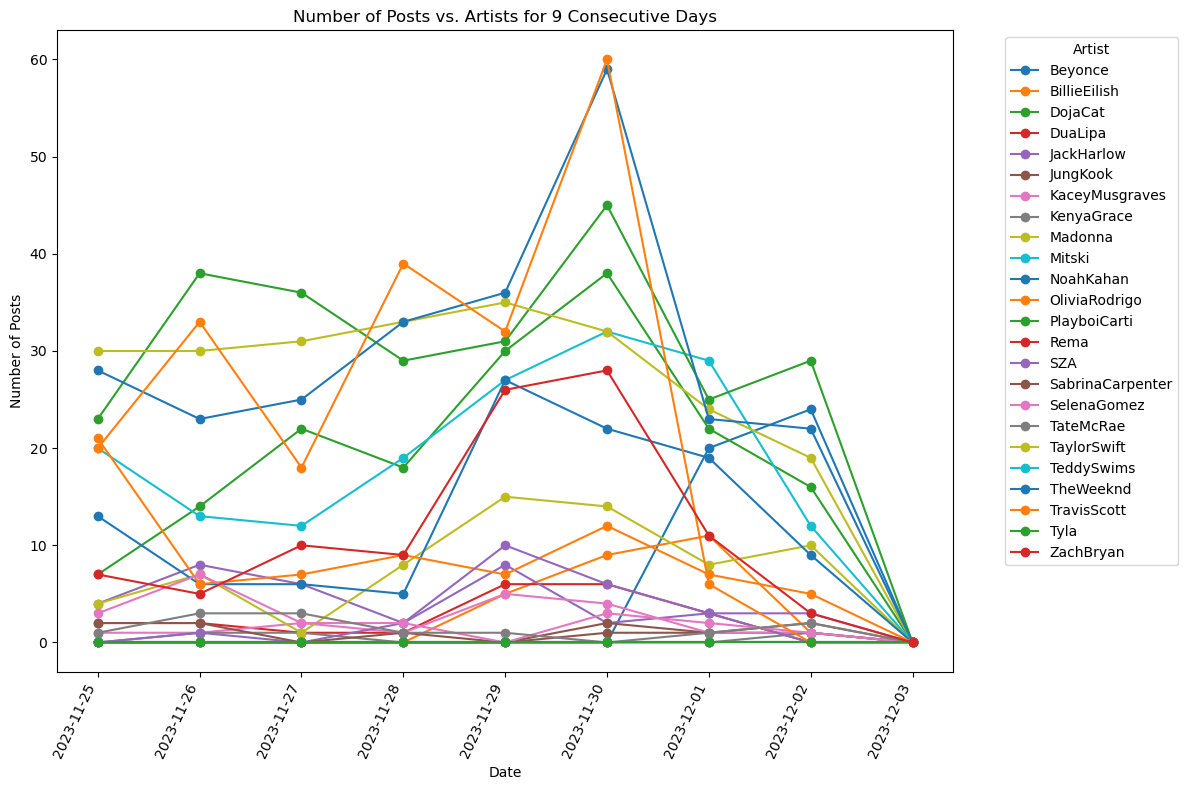

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient

conn = MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_posts

cursor = collection.find({})
data = list(cursor)

df = pd.DataFrame(data)

df['created_date'] = pd.to_datetime(df['created_date'])

unique_artists = df['artist'].unique()

start_date = pd.to_datetime('2023-11-25')  
num_days = 10

dfs = []

for artist in unique_artists:
   for i in range(num_days):
        date_filter = start_date + pd.DateOffset(days=i)
        filtered_data = df[(df['created_date'].dt.date == date_filter.date()) & (df['artist'] == artist)]

        num_posts = filtered_data.shape[0]

        date_str = date_filter.strftime("%Y-%m-%d")  
        dfs.append(pd.DataFrame({'date': [date_str], 'artist': [artist], 'num_posts': [num_posts]}))

result_df = pd.concat(dfs, ignore_index=True)

result_df = result_df.sort_values(by=['date'])

pivot_df = result_df.pivot(index='date', columns='artist', values='num_posts').fillna(0)

plt.figure(figsize=(12, 8))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], marker='o', label=col)

plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title(f'Number of Posts vs. Artists for {num_days} Consecutive Days')
plt.xticks(rotation=65, ha='right') 
plt.legend(title='Artist', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# for index, row in result_df.iterrows():
#     print(f"{row['date']} - {row['artist']}: {row['num_posts']} posts")

plt.show()


Song released by artist Taylor Swift ("Cruel Summer") on year 2019 is still trending and hitting the charts for 3 consecutive weeks. 
It is natuaral that songs release this year aroung this time will be on the charts - lets take month wise 

Jungkook ft. Latto - Seven is on charts for 6 months
Doja Cat - Paint the Town Red been for 4 months - rulling in ticktock and instagram reels
What was I made for (Barbie) from Billie Eilish for 7 months
Bad Bunny - MONACO been for 2 months.

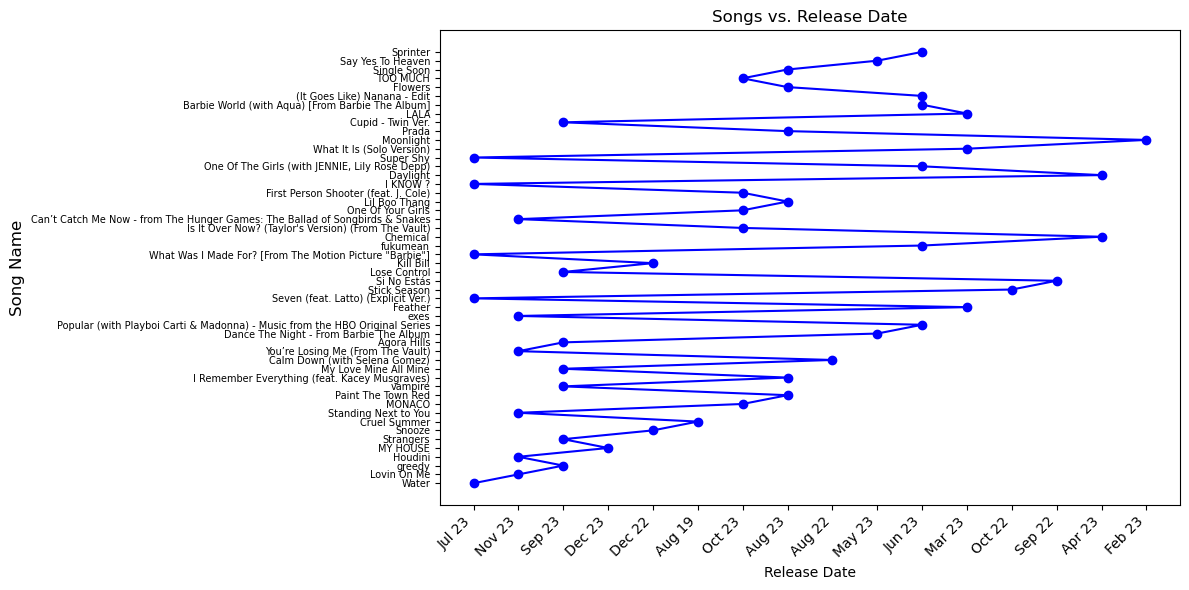

In [11]:
import matplotlib.pyplot as plt
from pymongo import MongoClient
from datetime import datetime

client = MongoClient('mongodb://127.0.0.1:27017/')
db = client.chestnut
collection = db.top_hits

cursor = collection.find({})
data = list(cursor)

song_names = [entry['track']['name'] for entry in data]
release_dates = [datetime.strptime(entry['track']['album']['release_date'], "%Y-%m-%d") for entry in data]
formatted_dates = [date.strftime("%b %y") for date in release_dates]

plt.figure(figsize=(12, 6))
plt.plot(formatted_dates, song_names, marker='o', linestyle='-', color='b')
plt.title('Songs vs. Release Date')
plt.xlabel('Release Date')
plt.ylabel('Song Name', fontsize=12)
plt.xticks(rotation=45, ha="right")  
plt.tick_params(axis='y', labelsize=7) 
plt.tight_layout()
plt.show()


In [3]:
import pymongo
from prettytable import PrettyTable

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.top_hits  

cursor = collection.find({})

artist_songs = {}

for document in cursor:
    if "track" in document:
        track_info = document["track"]
        
        artist_name = track_info["artists"][0]["name"]  
        song_name = track_info["name"]
        
    
        if artist_name not in artist_songs:
            artist_songs[artist_name] = []
        artist_songs[artist_name].append(song_name)

table = PrettyTable()
table.field_names = ["Artist", "Song"]

for artist, songs in artist_songs.items():
    song_list = "\n".join(songs)
    table.add_row([artist, song_list])

print(table[:20])


+-------------------+------------------------------------------------------------------------------+
|       Artist      |                                     Song                                     |
+-------------------+------------------------------------------------------------------------------+
|        Tyla       |                                    Water                                     |
|    Jack Harlow    |                                 Lovin On Me                                  |
|     Tate McRae    |                                    greedy                                    |
|                   |                                     exes                                     |
|      Dua Lipa     |                                   Houdini                                    |
|                   |                   Dance The Night - From Barbie The Album                    |
|      Beyoncé      |                                   MY HOUSE                           

Post Title: What are some of the coldest lyrics you have ever heard in a song?
Comment Body: That's why I fucked yo' bitch, you fat mothafucka!
--------------------------------------------------


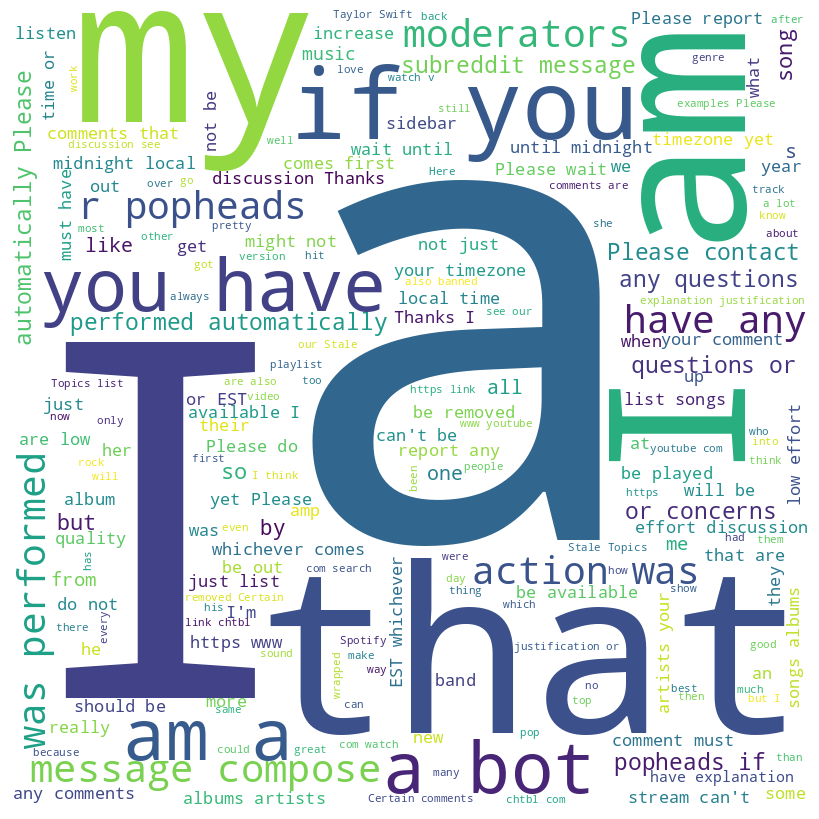

In [10]:
import requests
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pymongo import MongoClient

conn = MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection_comments = db["rComments"]

moderation_api_url = "https://api.moderatehatespeech.com/api/v1/moderate/"
api_token = "5e0a2d12fdbf8e404c114ce11e6730cc"

flagged_comments = []
all_comments = []

comments = collection_comments.find()

for comment in comments:
    comment_body = comment["comment_body"]
    post_title = comment.get("post_title", "Unknown Post")  

    moderation_api_request = {
        "token": api_token,
        "text": comment_body,
    }

    response = requests.post(moderation_api_url, json=moderation_api_request)

    if response.json().get("class") == "flag":
        flagged_comments.append({"post_title": post_title, "comment_body": comment_body})
    
    all_comments.append(comment_body)

for flagged_comment in flagged_comments:
    print(f"Post Title: {flagged_comment['post_title']}")
    print(f"Comment Body: {flagged_comment['comment_body']}")
    print("-" * 50)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(['the', 'and', 'in', 'to', 'is', 'it', 'of', 'this', 'for', 'on', 'with']), 
                min_font_size = 10).generate(' '.join(all_comments))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()


+---------------+--------------------------------------------------------------------------------------------------------------------+--------------------+
|  Artist Name  |                                                     Post Title                                                     | Number of Comments |
+---------------+--------------------------------------------------------------------------------------------------------------------+--------------------+
|  TaylorSwift  |                                    The Eras Tour Megathread: São Paulo, Brazil                                     |       10208        |
| OliviaRodrigo |                                            'GUTS World Tour' Megathread                                            |        4710        |
|  TaylorSwift  |                                        New old pic of Taylor posted by Jack                                        |        1716        |
|  TaylorSwift  | Tree Paine (Taylor’s publicist) addressing spe

Font 'default' does not have a glyph for '\u2728' [U+2728], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f451' [U+1f451], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2728' [U+2728], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\U0001f451' [U+1f451], substituting with a dummy symbol.


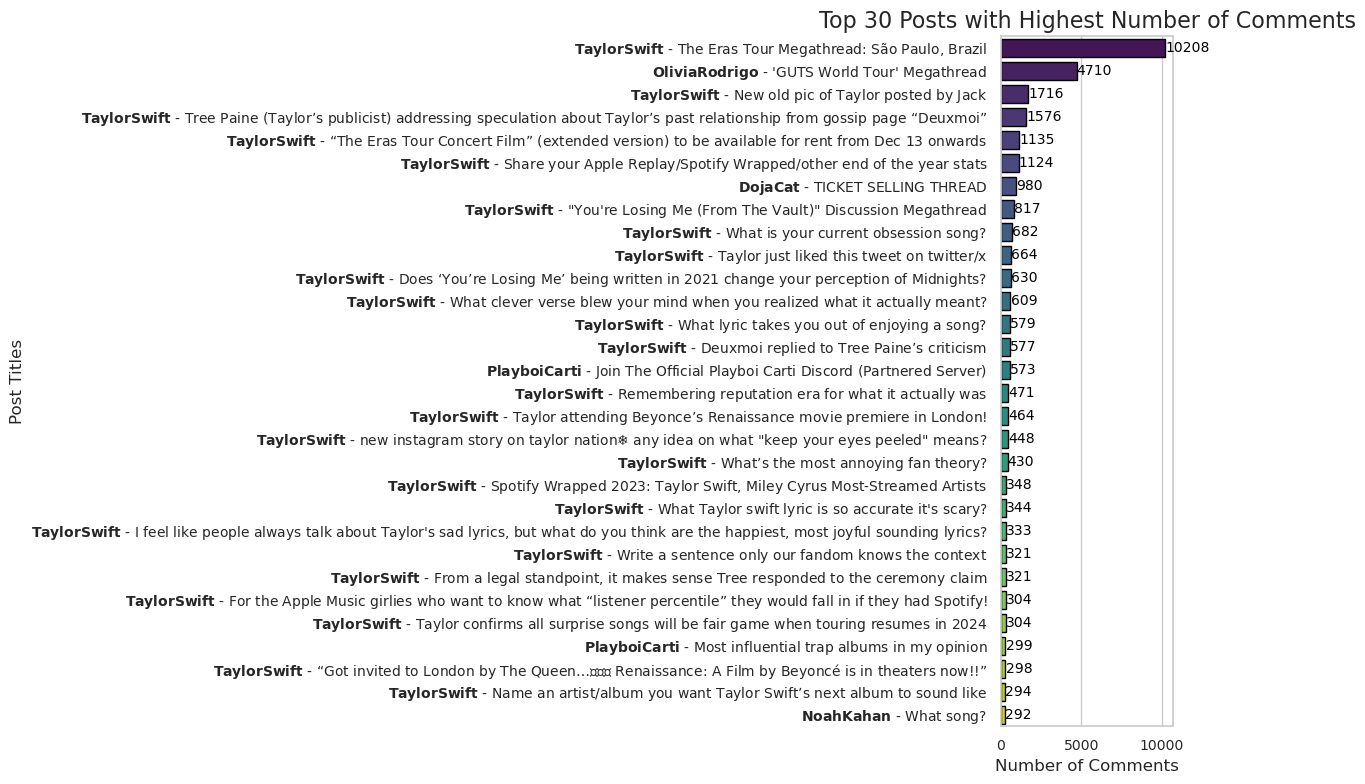

In [4]:
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_posts

cursor = collection.find().sort("number_of_comments", pymongo.DESCENDING).limit(30)

post_titles_with_artist = []
comment_counts = []

table = PrettyTable()
table.field_names = ["Artist Name", "Post Title", "Number of Comments"]

for post in cursor:
    artist_name = post["artist"]  
    post_title = post["post"]
    number_of_comments = post["number_of_comments"]
    formatted_artist = r"$\mathbf{" + artist_name + "}$"
    
    post_title_with_artist = f"{formatted_artist} - {post_title}"
    
    post_titles_with_artist.append(post_title_with_artist)
    comment_counts.append(number_of_comments)
    
    table.add_row([artist_name, post_title, number_of_comments])

table.float_format = "0.02"

print(table[:20])

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
bars = sns.barplot(x=comment_counts, y=post_titles_with_artist, palette="viridis", edgecolor="black")

for bar, count, title_with_artist in zip(bars.patches, comment_counts, post_titles_with_artist):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, f'{count}', ha='left', va='center', fontsize=10, color='black')
plt.title('Top 30 Posts with Highest Number of Comments', fontsize=16)
plt.xlabel('Number of Comments', fontsize=12)
plt.ylabel('Post Titles', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /home/dshetty3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dshetty3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+---------+-----------+
|   Word  | Frequency |
+---------+-----------+
|   song  |    202    |
| spotify |    199    |
|  songs  |    176    |
| wrapped |    158    |
|  music  |    146    |
|  taylor |    135    |
|   new   |    118    |
|   top   |    110    |
|   tour  |     96    |
|   like  |     93    |
+---------+-----------+


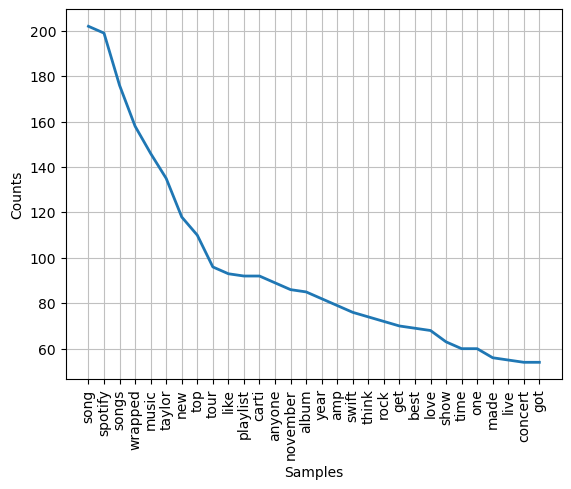

In [8]:
import pymongo
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import nltk

nltk.download('punkt')
nltk.download('stopwords')

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut

subreddits = ['rSpotify', 'rMusic', 'rPopheads', 'artists_posts']

all_titles = ''
for subreddit in subreddits:
    collection = db[subreddit]
    posts = collection.find({}, {"post": 1, "_id": 0})
    all_titles += ' '.join([post['post'] for post in posts])

tokens = word_tokenize(all_titles)

stop_words = set(stopwords.words('english'))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

fdist = FreqDist(filtered_tokens)

table = PrettyTable(["Word", "Frequency"])

for word, frequency in fdist.most_common(10):
    table.add_row([word, frequency])
    #print(f"{word}: {frequency}")

print(table)

fdist.plot(30, cumulative=False)
plt.show()


- This is a general wordcloud from all the subreddits posts.

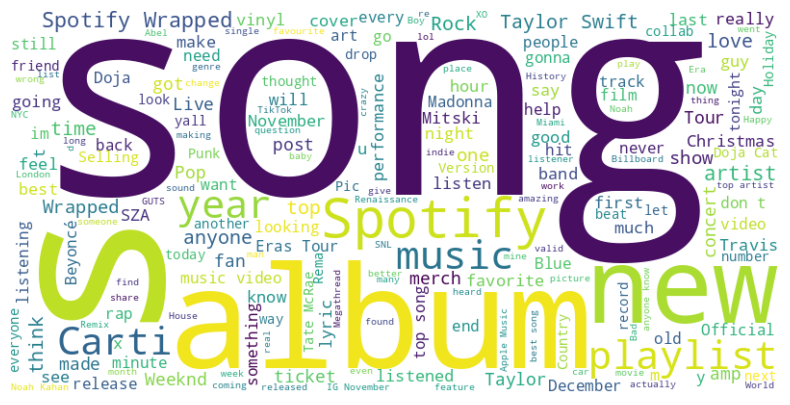

In [9]:
import pymongo
from pymongo import MongoClient
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut

subreddits = ['rSpotify', 'rMusic', 'rPopheads', 'artists_posts']

all_titles = ''
for subreddit in subreddits:
    collection = db[subreddit]
    posts = collection.find({}, {"post": 1, "_id": 0})
    all_titles += ' '.join([post['post'] for post in posts])

wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=200).generate(all_titles)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
import subprocess

subprocess.run("pipx install spotipy --include-deps --force", shell=True)
subprocess.run("pipx ensurepath", shell=True)


In [11]:
import json
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from pymongo import MongoClient
from prettytable import PrettyTable
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

client = MongoClient('mongodb://127.0.0.1:27017/')
database = client['chestnut']
collection_names = ['rMusic', 'rPopheads', 'rSpotify']

json_data = []
for collection_name in collection_names:
    collection = database[collection_name]
    cursor = collection.find({})
    json_data.extend(list(cursor))

proper_nouns = []
for item in json_data:
    post_text = item["post"]
    sentences = sent_tokenize(post_text)
    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged_words = pos_tag(words)
        
        current_proper_noun = ""
        for word, pos in tagged_words:
            if pos == 'NNP' and word[0].isupper():
                current_proper_noun += word + " "
            elif current_proper_noun:
                proper_nouns.append(current_proper_noun.strip())
                current_proper_noun = ""
        
        if current_proper_noun:
            proper_nouns.append(current_proper_noun.strip())

artists = [re.sub(r'\s+', '', item) for item in proper_nouns if ' ' in item]

client_id = 'a8731e57f8ef4c83a7623a1f8182dde9'
client_secret = 'a1063792310642e8902a951dc42fe92c'

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

unique_artists = set()
for artist_name in artists:
    result = sp.search(q=artist_name, type='artist')
    
    if 'artists' in result and 'items' in result['artists'] and result['artists']['items']:
        artist = result['artists']['items'][0]
        if artist['popularity'] > 80:
            unique_artists.add((artist['name'], artist['popularity']))

table = PrettyTable()
table.field_names = ["Artist", "Popularity"]
for artist, popularity in unique_artists:
    table.add_row([artist, popularity])

print(table)


[nltk_data] Downloading package punkt to /home/dshetty3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dshetty3/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['Bands/Artist', 'Albums', 'Favourite', 'Depeche Mode', 'Me Down Again', 'Synth-pop', 'Pearl Jam', 'Evolution', 'Hard Rock', 'Wheel', 'Corniness', 'Favourite', 'L', 'Devil', 'Son', 'Rap', 'Trust', 'Me How', 'Skunk Anansie', 'Charlie Big Potato', 'Alterative Rock', 'Tribe Called Quest', 'Buggin', 'Out', 'Jazz Rap', 'Elton John', 'Ballad', 'A', 'Gun', 'Rock', 'Mazzy Star', 'Kingdom', 'Wire', 'Fly', 'Punk', 'Dave Gahan', 'Beastie Boys', 'Hip-Hop', 'George Michael', 'Father Figure', 'Pop', 'Who', 'Generation', 'Rock', 'Gorillaz', 'Stylo', 'Electro-funk', 'Eminem', 'Crazy Town', 'Butterfly', 'Remix', 'REDSMITHVII', 'Chemical Oblivion', 'Post-emo/Pop-Punk', 'Dirty Streets', 'Modern Blues Rock/Psych', 'Prince', 'Rock', 'Taylor Swift', 'Rio', 'Spotify', 'Uruguay', 'Crimson', 'Prog-rock', 'Bad', 'Black Sabbath', 'Help', 'Favorite', 'Hot Chocolate', 'Winner', 'Groove/Funk', 'Ratt', 'Cartoon', 'Christopher Lee', 'Jingle Hell', 'Heavy Metal', 'Christmas Music', 'Sonic Youth', 'Heather', 'Alternati

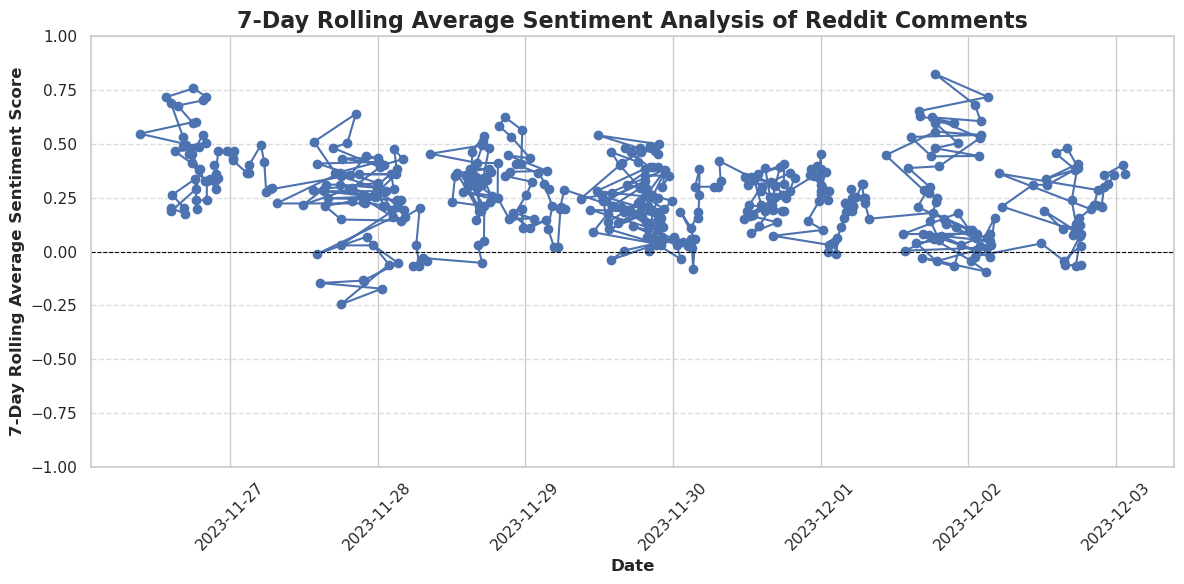

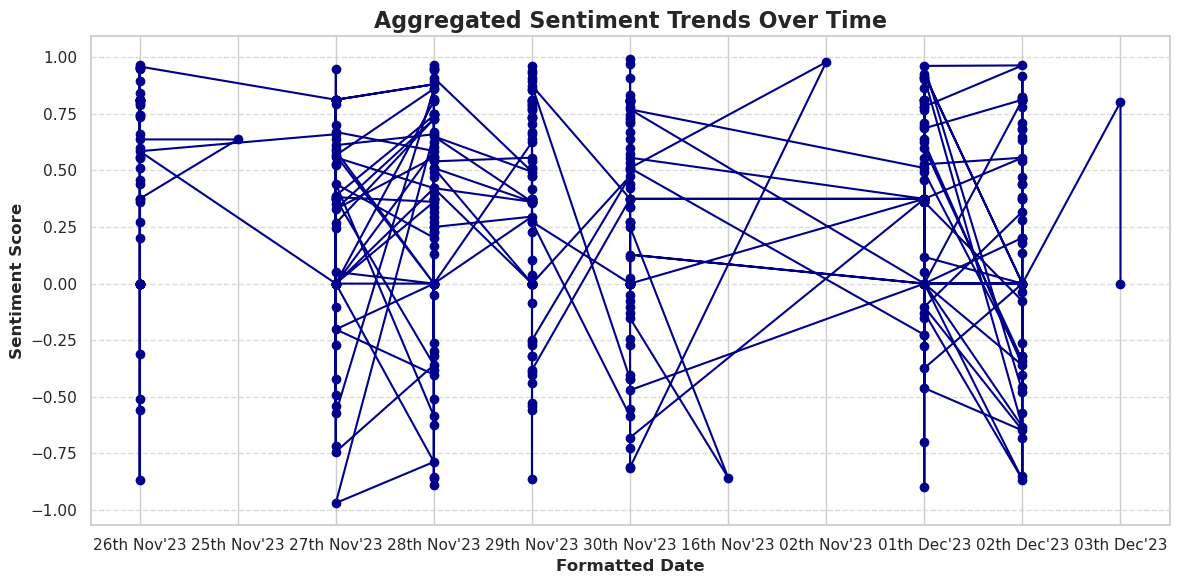

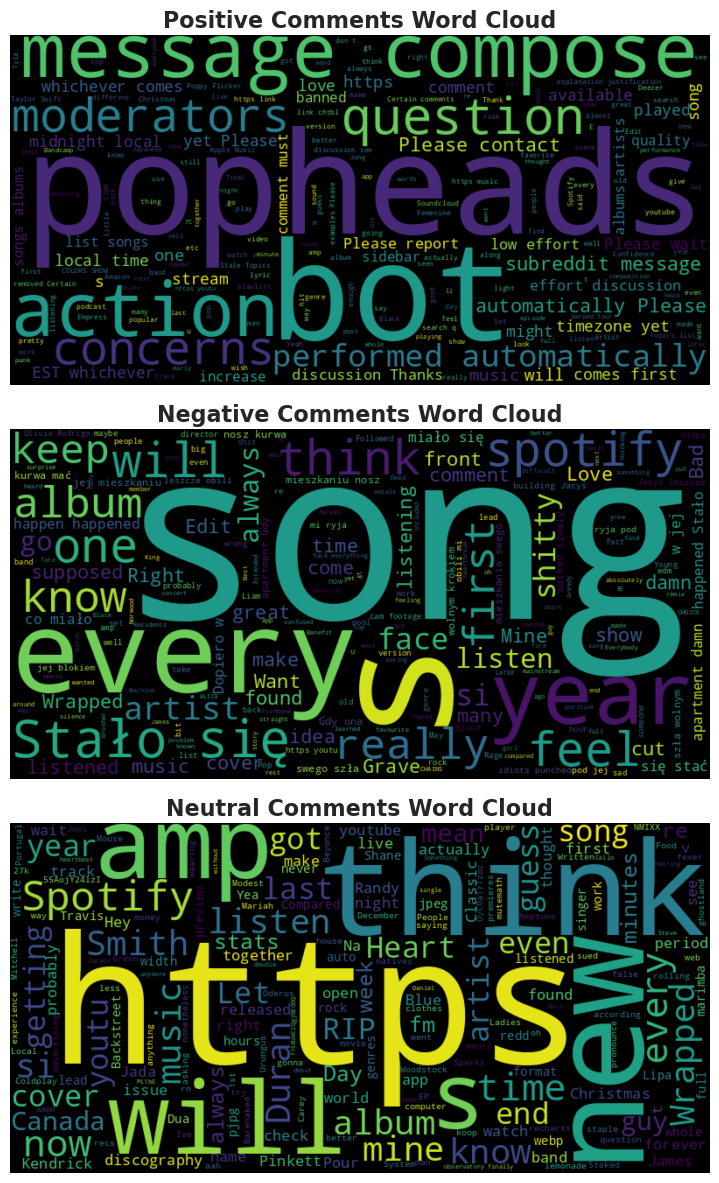

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from pymongo import MongoClient
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

client = MongoClient('mongodb://127.0.0.1:27017/')

db = client.chestnut
collection = db.rComments

comments_data = list(collection.find({}, {"comment_body": 1, "comment_created_date": 1, "_id": 0}))

comments = [comment["comment_body"] for comment in comments_data]
dates = [comment["comment_created_date"] for comment in comments_data]

sia = SentimentIntensityAnalyzer()

sentiments = [sia.polarity_scores(comment)["compound"] for comment in comments]

dates = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S UTC') for date in dates]

formatted_dates = [date.strftime('%dth %b\'%y') for date in dates]

df = pd.DataFrame({"Date": dates, "Formatted Date": formatted_dates, "Sentiment": sentiments})

df.set_index('Date', inplace=True)

df_filtered = df[df.index >= datetime(2023, 11, 25)]

rolling_avg_sentiments = df_filtered['Sentiment'].rolling(window=9).mean()

plt.figure(figsize=(12, 6))
plt.plot(rolling_avg_sentiments.index, rolling_avg_sentiments.values, marker='o', linestyle='-', color='b')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('7-Day Rolling Average Sentiment Score', fontsize=12, fontweight='bold')
plt.title('7-Day Rolling Average Sentiment Analysis of Reddit Comments', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.ylim([-1, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Formatted Date'], df['Sentiment'], marker='o', linestyle='-', color='darkblue')
plt.xlabel('Formatted Date', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Aggregated Sentiment Trends Over Time', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

positive_comments = [comment for comment, sentiment in zip(comments, sentiments) if sentiment > 0]
negative_comments = [comment for comment, sentiment in zip(comments, sentiments) if sentiment < 0]
neutral_comments = [comment for comment, sentiment in zip(comments, sentiments) if sentiment == 0]

positive_wordcloud = WordCloud(width=800, height=400).generate(' '.join(positive_comments))
negative_wordcloud = WordCloud(width=800, height=400).generate(' '.join(negative_comments))
neutral_wordcloud = WordCloud(width=800, height=400).generate(' '.join(neutral_comments))

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Comments Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Comments Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Comments Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()


Top Songs discussed on Reddit posts:

Stick Season, Cruel Summer, Houdini, Paint the Town Red, greedy have been discussed a lot on the Redddit platform.

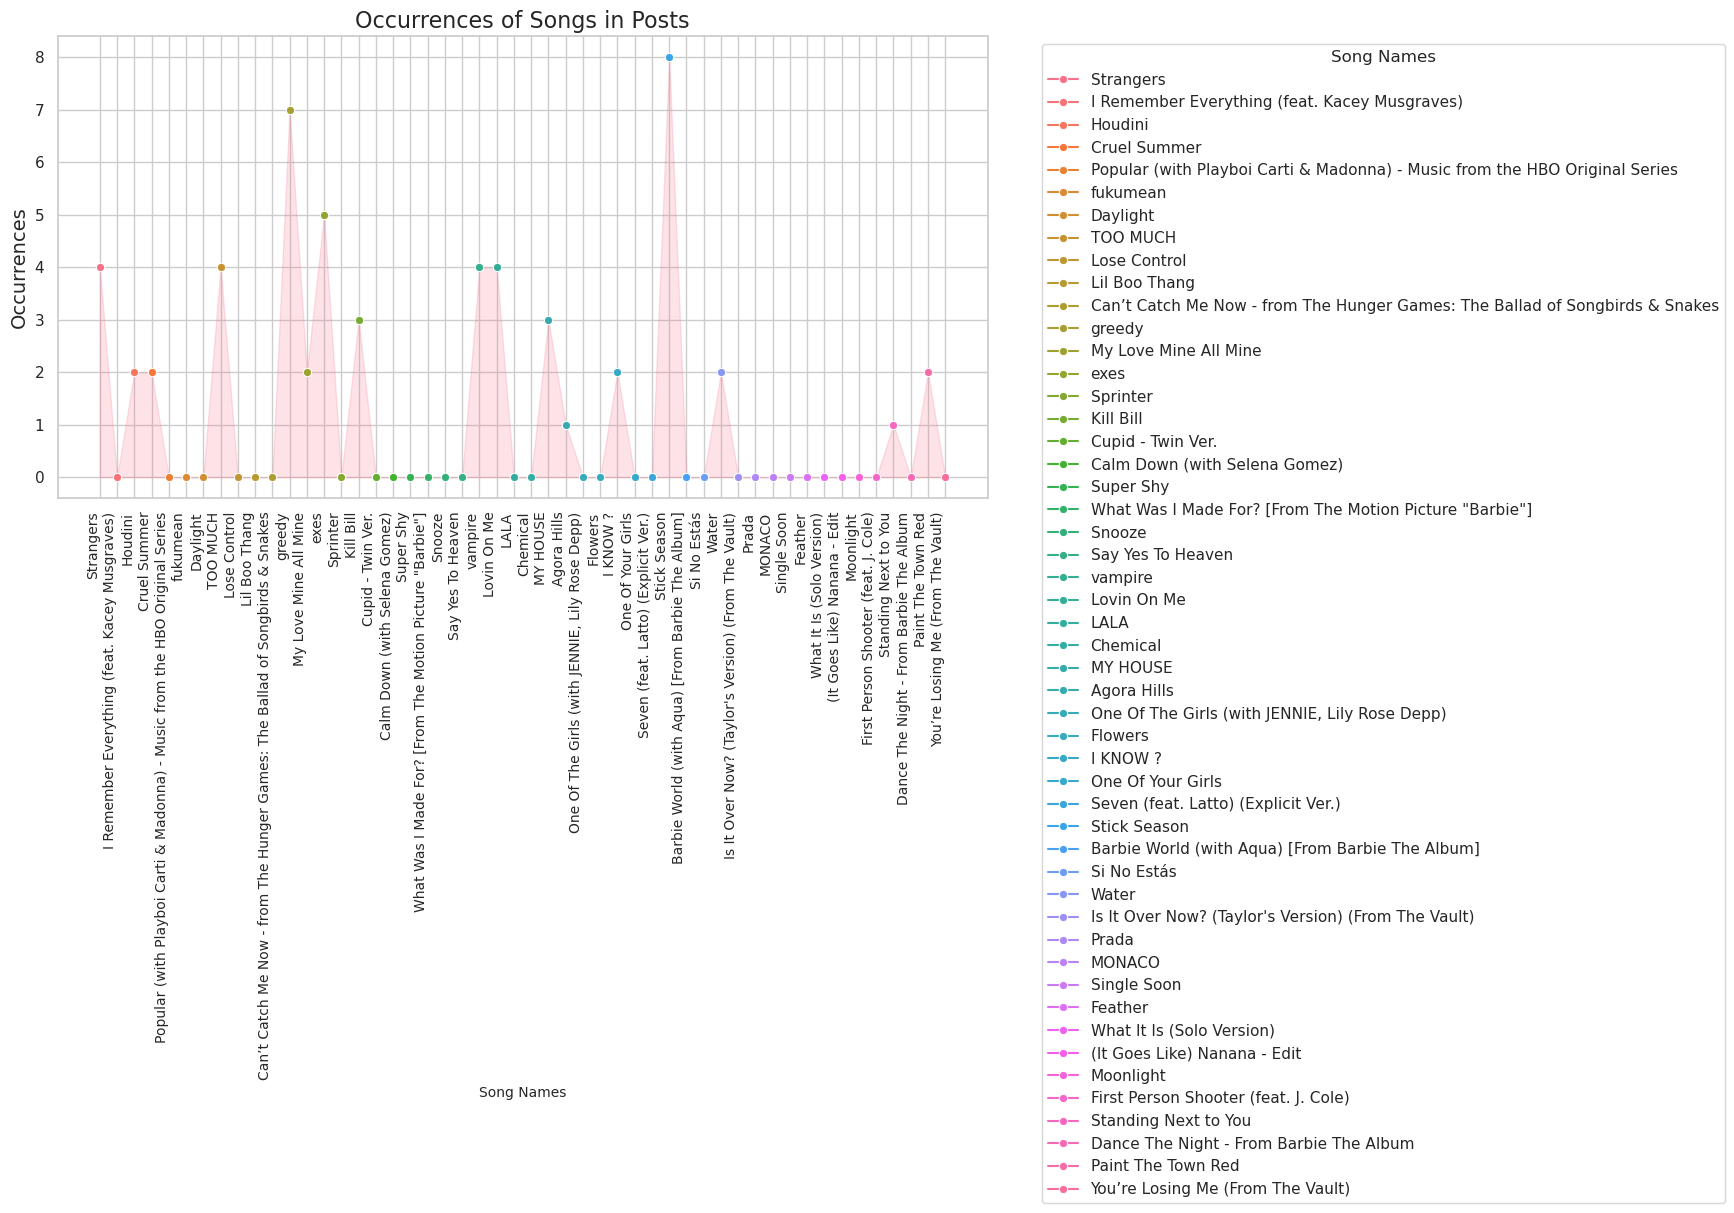

Songs with More Than One Occurrence:
Strangers: 4 occurrences
Houdini: 2 occurrences
Cruel Summer: 2 occurrences
TOO MUCH: 4 occurrences
greedy: 7 occurrences
My Love Mine All Mine: 2 occurrences
exes: 5 occurrences
Kill Bill: 3 occurrences
vampire: 4 occurrences
Lovin On Me: 4 occurrences
MY HOUSE: 3 occurrences
I KNOW ?: 2 occurrences
Stick Season: 8 occurrences
Water: 2 occurrences
Paint The Town Red: 2 occurrences


In [13]:
from pymongo import MongoClient
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to MongoDB
conn = MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_posts
collection_spotify = db.top_hits

cursor = collection_spotify.find({})
song_names = [entry["track"]["name"] for entry in cursor]
unique_song_names = list(set(song_names))

posts_cursor = collection.find({})

song_occurrences = {song: 0 for song in unique_song_names}
for post_entry in posts_cursor:
    post_text = post_entry["post"]
    for song in unique_song_names:
        if song.lower() in post_text.lower():
            song_occurrences[song] += 1

table = [["Song Names", "Occurrences"]] + [[name, song_occurrences[name]] for name in unique_song_names]

table_format = "fancy_grid"
numalign = "center" 
stralign = "center"  

colors = sns.color_palette("husl", len(unique_song_names))

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

for i, song_name in enumerate(unique_song_names):
    sns.lineplot(x=[song_name], y=[song_occurrences[song_name]], marker='o', color=colors[i], label=song_name)

ax.fill_between(unique_song_names, [song_occurrences[song_name] for song_name in unique_song_names], color=colors[0], alpha=0.2)

ax.set_ylabel('Occurrences', fontsize=14)
ax.set_xlabel('Song Names', fontsize=10)
ax.set_title('Occurrences of Songs in Posts', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.legend(title='Song Names', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

multiple_occurrence_songs = [song for song, occurrences in song_occurrences.items() if occurrences > 1]

print("Songs with More Than One Occurrence:")
for song_name in multiple_occurrence_songs:
     print(f"{song_name}: {song_occurrences[song_name]} occurrences")


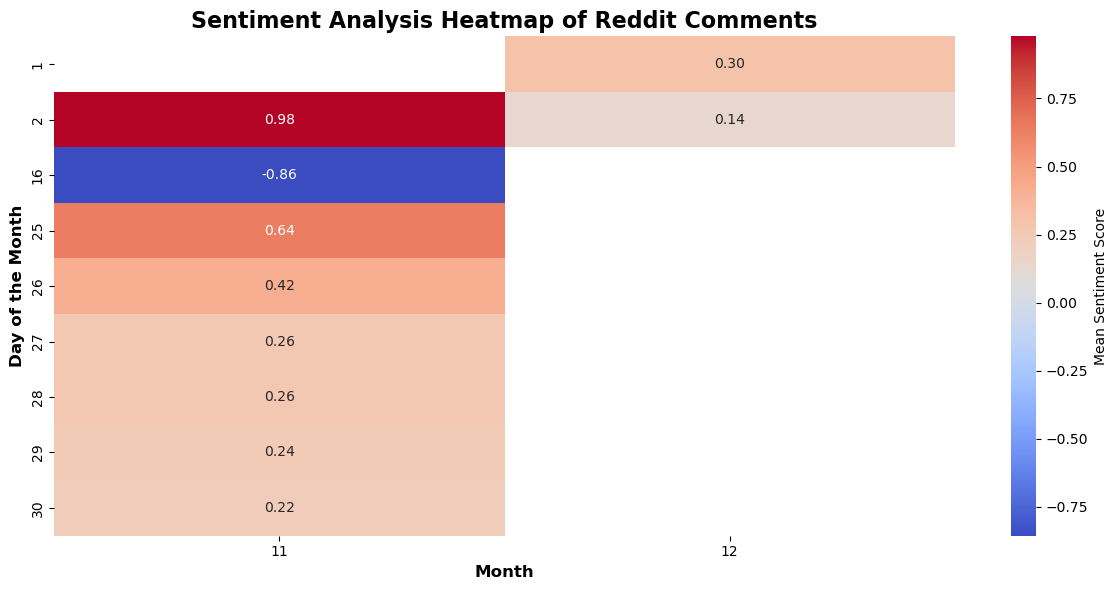

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
from pymongo import MongoClient
from nltk.sentiment import SentimentIntensityAnalyzer

client = MongoClient('mongodb://127.0.0.1:27017/')

db = client.chestnut
collection = db.rComments

comments_data = list(collection.find({}, {"comment_body": 1, "comment_created_date": 1, "_id": 0}))

comments = [comment["comment_body"] for comment in comments_data]
dates = [comment["comment_created_date"] for comment in comments_data]

sia = SentimentIntensityAnalyzer()

sentiments = [sia.polarity_scores(comment)["compound"] for comment in comments]

dates = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S UTC') for date in dates]

df = pd.DataFrame({"Date": dates, "Sentiment": sentiments})

df_resampled = df.resample('D', on='Date').mean()

heatmap_data = df_resampled.pivot_table(index=df_resampled.index.day, columns=df_resampled.index.month, values='Sentiment')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Sentiment Score'})
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Day of the Month', fontsize=12, fontweight='bold')
plt.title('Sentiment Analysis Heatmap of Reddit Comments', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Conclusion:

Now that Spotify has release the Spotify Wrapped for year 2023:

Looking at the analysis we have done:

Artists trending with all the considered factors we have collected from the Reddit and Spotify data it shows that the artists who will make the list will be :

Taylor Swift, Travis Scott, Bad Bunny, The Weekend, SZA

                                            --------- RESEARCH QUESTION 3 DONE --------